# Exploring the FuseTS Toolbox: Fusing Optical and SAR Data for Phenology Analysis

Welcome to the showcase of the FuseTS library, an integral part of the AI4FOOD project, presented at the FOSS4G conference. In this Jupyter notebook, we will demonstrate how the FuseTS library enables users to effectively fuse optical and SAR data, harnessing the power of fused data sets combined time series analytics for extracting valuable phenology information.

Throughout this notebook, we will compare the results obtained from a raw dataset with those obtained from the fused dataset, illustrating the significant improvements in extracting phenology information. By integrating optical data, which provides detailed spectral information, with SAR data, which excels in all-weather and day-night imaging, the FuseTS library empowers users to unlock deeper insights into vegetation dynamics and crop monitoring.

**Prerequisites**

- You can start from a clean **Python 3.8** environment. During this notebook, we'll be installing the necessary dependencies.
- In this notebook, we utilize openEO to retrieve time series data. To leverage the full range of openEO features, you can create a free trial account on the [openEO Platform](https://docs.openeo.cloud/join/free_trial.html)  and receive 1000 free credits, enabling you to execute the functionalities showcased in this notebook.

Lets start with importing the different libraries that we need within this notebook.


## Setting up the environment
First of all we need to make sure that all our dependencies are correctly installed. 

In [37]:
# Do not execute this cell when using the Docker image
!pip install -r requirements.txt
!pip install numpy cython
!pip install ../../.

Processing c:\users\1\desktop\drive\ai4food\repo\fusets
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for fusets: filename=fusets-0.0.1-py3-none-any.whl size=40193 sha256=c603e2996e56f6451b013dfda61b4047a4633ad64631b82653ffc5702f988c06
  Stored in directory: C:\Users\1\AppData\Local\Temp\pip-ephem-wheel-cache-m0dwb3e2\wheels\1a\24\e6\bd14642b38b3139f0ff7f9ec975210308b7344f5e6865e0d75
Successfully built fusets
  Attempting uninstall: fusets
    Found existing installation: fusets 0.0.1
    Uninstalling fusets-0.0.1:
      Successfully uninstalled fusets-0.0.1


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [38]:
import os
import sys

import datetime
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import openeo
import xarray
from ipyleaflet import GeoJSON, Map
from datetime import datetime, timedelta


from openeo.rest.conversions import timeseries_json_to_pandas
from openeo.processes import eq

from fusets.analytics import phenology
from fusets.whittaker import whittaker
from fusets.mogpr import mogpr_1D

warnings.filterwarnings('ignore')

# PART 1: Downloading the raw S2 NDVI time series

We start by downloading the raw S2 NDVI data that we need for our analysis. Retrieving time series data can be done through various methods, and one such method is using openEO. [OpenEO](https://openeo.org/) is an API that provides access to a variety of Earth Observation (EO) data and processing services in a standardized and easy-to-use way. By leveraging the power of openEO, we can easily retrieve the time series data for the meadow and use it to analyze the patterns and trends.

More information on the usage of openEO's Python client can be found on [GitHub](https://github.com/Open-EO/openeo-python-client).

The first step is to connect to an openEO compatible backend.


In [39]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()


OIDC token response did not contain refresh token.


Authenticated using refresh token.


Next we define the area of interest, in this case an extent, for which we would like to fetch time series data.


In [40]:
year = 2019
spat_ext = {
    "coordinates": [
        [
            [-4.875091217039325, 41.77290587433312],
            [-4.872773788450457, 41.77290587433312],
            [-4.872773788450457, 41.77450614847532],
            [-4.875091217039325, 41.77450614847532],
            [-4.875091217039325, 41.77290587433312],
        ]
    ],
    "type": "Polygon",
}
temp_ext = [f"{year}-01-01", f"{year}-12-30"] 

Plot the area to see what we're working with.


In [41]:
center = np.mean(spat_ext["coordinates"][0], axis=0).tolist()[::-1]
zoom = 15

m = Map(center=center, zoom=zoom)
g = GeoJSON(
    data=spat_ext,
    style={
        "color": "red",
        "opacity": 1,
        "weight": 1.9,
        "dashArray": "9",
        "fillOpacity": 0.5,
    },
)
m.add(g)
m


Map(center=[41.773545983990005, -4.874164245603778], controls=(ZoomControl(options=['position', 'zoom_in_text'…

We will create an openEO process to calculate the NDVI time series for our area of interest. We'll begin by using the `SENTINEL2_L2A_SENTINELHUB` collection, and apply a cloud masking algorithm to remove any interfering clouds before calculating the NDVI values.


In [42]:
s2 = connection.load_collection(
    "SENTINEL2_L2A_SENTINELHUB",
    spatial_extent=spat_ext,
    temporal_extent=temp_ext,
    bands=["B04", "B08", "SCL"],
)
s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")
s2 = s2.mask_polygon(spat_ext)
ndvi_cube = s2.ndvi(red="B04", nir="B08", target_band="NDVI")


Now that we have calculated the NDVI time series for our area of interest, we can request openEO to download the result to our local storage. This will allow us to access the file and use it for further analysis in this notebook.


In [43]:
ndvi_output_file = "./raw_s2_ndvi_field.nc"

# the following code downloads the data, it is commented out,
# since the data was prepared in advance to save time

# ndvi_job = ndvi_cube.execute_batch(
#     ndvi_output_file, title=f"FOSS4G - FUSETS - Phenology - Raw NDVI", out_format="netCDF"
# )


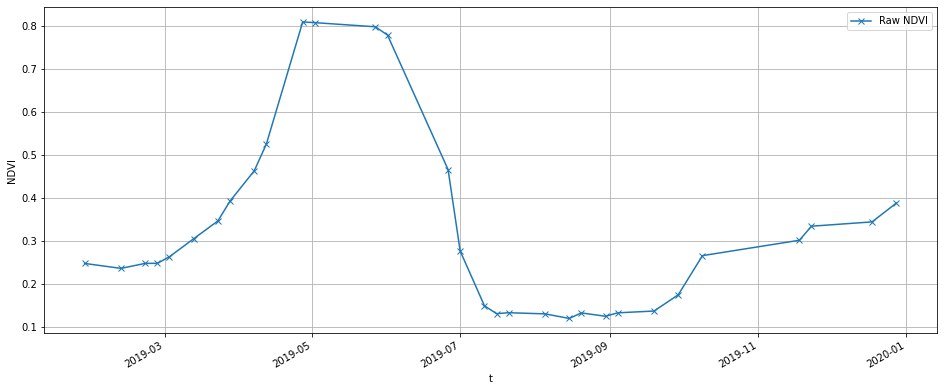

In [44]:
raw_ndvi_ds = xarray.load_dataset(ndvi_output_file)
raw_ndvi = raw_ndvi_ds.NDVI.rename({"t": "time"})

fig, ax = plt.subplots(figsize=(16, 6))

raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, marker='x', label='Raw NDVI')
ax.legend()
ax.grid()


## PART 2: Creating a smoothed dataset using Whittaker

The Whittaker function is available in the FuseTS toolbox and can be used to create a smoothed time series. It employs a discrete penalized least squares algorithm that fits a smooth series, denoted as z, to the original data series, denoted as y. 

Whittaker smoother represents a computationally efficient reconstruction method for smoothing and gap-filling of time series which is why it is used here.

Eilers, P. H., 2003: A perfect smoother. Analytical chemistry, 75 (14), 3631–3636.



In [45]:
smoothed = whittaker(raw_ndvi)

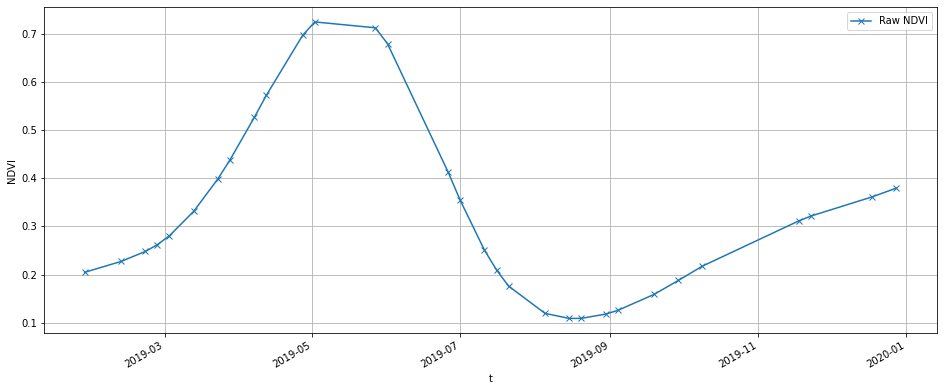

In [46]:
fig, ax = plt.subplots(figsize=(16, 6))

smoothed.median(dim=["x", "y"]).plot(ax=ax, marker='x', label='Raw NDVI')
ax.legend()
ax.grid()

## PART 3: Creating a fused data set using MOGPR
In this section, we will begin the process of creating our first fused dataset using the MOGPR (Multi-Output Gaussian Process Regression) technique. The fusion process will involve combining Sentinel-1 (S1) RVI and Sentinel-2 (S2) NDVI data. To accomplish this, we will leverage the powerful capabilities of the FuseTS library. 

### Calculating the S1 RVI and S2 NVDI timeseries
As the first step, we will use openEO to download the S1 RVI and S2 NDVI time series data required as input for the MOGPR service. This process ensures that we have the necessary data available for further fusion using the MOGPR algorithm.


In [47]:
def calculate_rvi(dc):
    VH = dc.band("VH")
    VV = dc.band("VV")
    return (VH + VH) / (VV + VH)

    
# RVI DESCENDING
s1_desc = connection.load_collection('SENTINEL1_GRD',
                                    spatial_extent = spat_ext,
                                    temporal_extent=temp_ext,
                                    bands=["VH","VV"],
                                    properties={
                                       "sat:orbit_state": lambda x: eq(x, 'DESCENDING'),
                                       "resolution": lambda x: eq(x, 'HIGH'),
                                       "sar:instrument_mode": lambda x: eq(x, 'IW')                                     
                                    }
                                   )
mogpr_rvi_desc_cube = calculate_rvi(s1_desc)


# RVI ASCENDING
s1_asc = connection.load_collection('SENTINEL1_GRD',
                                    spatial_extent = spat_ext,
                                    temporal_extent=temp_ext,
                                    bands=["VH","VV"],
                                    properties={
                                       "sat:orbit_state": lambda x: eq(x, 'ASCENDING'),
                                       "resolution": lambda x: eq(x, 'HIGH'),
                                       "sar:instrument_mode": lambda x: eq(x, 'IW')                                     
                                    }
                                   )
mogpr_rvi_asc_cube = calculate_rvi(s1_asc)


# NDVI
s2 = connection.load_collection('SENTINEL2_L2A_SENTINELHUB',
                                spatial_extent=spat_ext,
                                temporal_extent=temp_ext,
                                bands=["B04","B08","SCL"])
s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")
mogpr_ndvi_cube = s2.ndvi(red="B04", nir="B08")

Next, we will utilize openEO to calculate the time series for our Area of Interest (AOI) for each of the input datasets for MOGPR.

In [48]:
output_file = 'mogpr_input.csv'

cubes_dfs = []
for cube in [mogpr_ndvi_cube, mogpr_rvi_desc_cube, mogpr_rvi_asc_cube]:
    timeseries = cube.polygonal_mean_timeseries(spat_ext).execute()
    timeseries_df = timeseries_json_to_pandas(timeseries)
    timeseries_df.index = pd.to_datetime(timeseries_df.index)
    cubes_dfs.append(timeseries_df) 

# Join signals
mogpr_df = pd.concat(cubes_dfs, axis=1)
mogpr_df = mogpr_df.rename(columns={0: 'NDVI', 1: 'RVI_DESC', 2: 'RVI_ASC'})
mogpr_df.to_csv(output_file)

mogpr_df = pd.read_csv(output_file)
mogpr_df["date"] = pd.to_datetime(mogpr_df["date"])
mogpr_df.set_index("date", inplace = True)

(0.0, 1.0)

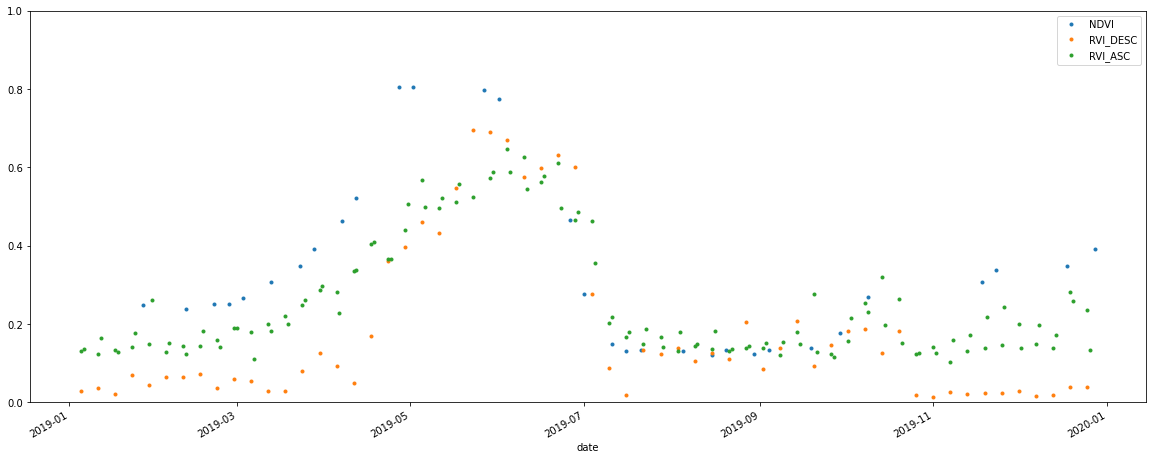

In [49]:
plot = mogpr_df.plot(figsize=(20,8), marker='.', linestyle='None')
fig = plot.get_figure()
ax = fig.gca()
ax.set_ylim([0, 1])

### Executing MOGPR
In order to process the time series data, some additional preprocessing is required to execute the MOGPR algorithm. This includes extracting the different time steps that are available in the input data.

In [50]:
# Use only 2 signals
signals = ['NDVI', 'RVI_DESC']

time_step = 5
time       = []
data       = []
time_str   = []

for signal in signals:
    time_vec_num = np.asarray([ _.toordinal() for _ in mogpr_df.index], dtype=np.float64)        
    time.append(time_vec_num)
    data.append(mogpr_df[signal].to_numpy())         

time_vec_min        = np.min(list(pd.core.common.flatten(time)))
time_vec_max        = np.max(list(pd.core.common.flatten(time)))
output_timevec      = np.array(range(int(time_vec_min), int(time_vec_max), time_step), dtype = np.float64)  
output_time         = [datetime.fromordinal(int(_)) for _ in output_timevec]

In [51]:
master_ind = 1
nt = 1
out_mean, out_std, out_qflag, out_model = mogpr_1D(data[:], time[:],master_ind,output_timevec,nt)

Let's convert the output of the service to a pandas dataframe and plot the results.

In [52]:
nout = len(out_mean)
out_mean_list = []
for ind in range(nout):
    out_mean_list.append(out_mean[ind].ravel())
    
mogpr = pd.DataFrame(np.column_stack(out_mean_list), columns=signals)
mogpr['time'] = output_time
mogpr.set_index('time', inplace=True)

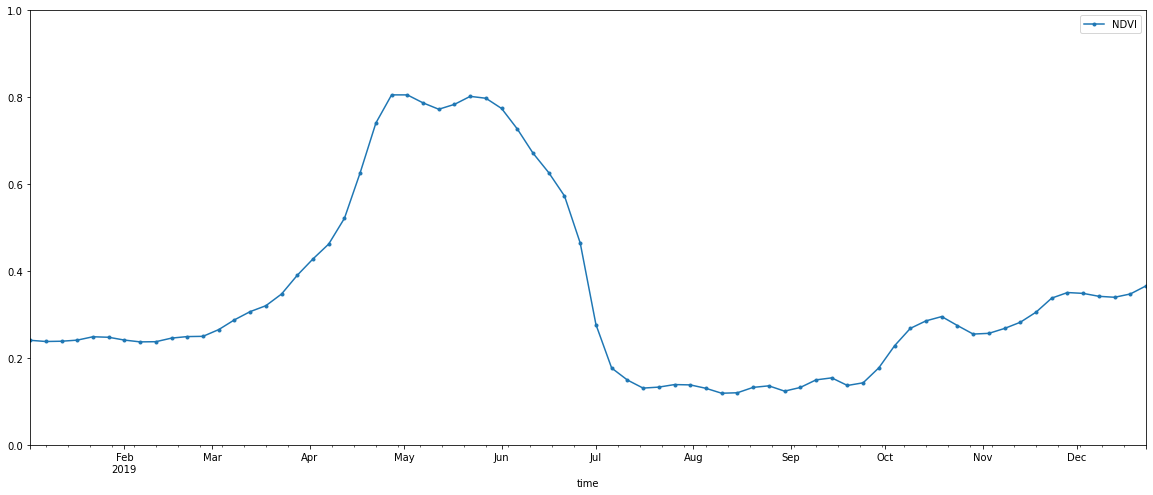

In [53]:
plot = mogpr['NDVI'].plot(figsize=(20,8), marker='.', linestyle='-')
fig = plot.get_figure()
ax = fig.gca()
ax.set_ylim([0, 1])
ax.legend()

## PART 4: Creating the fused data set using CropSAR

In the following section, we will leverage the capabilities of the toolbox to generate a fused dataset using CropSAR. The CropSAR service is specifically designed to enhance crop monitoring and analysis by integrating Sentinel-2 optical observations with Sentinel-1 radar data. This fusion process empowers users to monitor agricultural fields regardless of weather conditions or daylight availability, making it an invaluable tool for comprehensive crop assessment.

To execute the CropSAR service and obtain the fused dataset, we will once again utilize openEO. By leveraging openEO, we can easily harness the power of CropSAR and efficiently download the fused dataset, enabling further analysis and extraction of valuable phenology information in the next part.  The CropSAR service is exposed as a public openEO [user-defined process (UDP)](https://open-eo.github.io/openeo-python-client/udp.html#user-defined-processes), enabling easy re-use and integration into any existing workflow.

In [54]:
service = "CropSAR_px"
namespace = "vito"


In [55]:
cropsar_cube = connection.datacube_from_process(
    service,
    namespace=namespace,
    geometry=spat_ext,
    startdate=temp_ext[0],
    enddate=temp_ext[1],
    version=2,
    model_path="tmp/model/cnn_transformer/",
    path_extras=["tmp/env/env/"],
)

In [56]:
cropsar_output_file = "./cropsar_ndvi.nc"

# the following code downloads the data, it is commented out,
# since the data was prepared in advance to save time

# cropsar_job = cropsar_cube.execute_batch(
#     cropsar_output_file,
#     title="FOSS4G - FUSETS - Phenology - CropSAR",
#     out_format="netcdf",
#     job_options={
#         "executor-cores": "8",
#         "task-cpus": "8",
#         "executor-memoryOverhead": "2g",
#         "udf-dependency-archives": [
#             "https://artifactory.vgt.vito.be/auxdata-public/cropsar_px/20230504T175919_cnn_transformer.zip#tmp/model/cnn_transformer",
#             "https://artifactory.vgt.vito.be/auxdata-public/cropsar_px/env.tar.gz#tmp/env",
#         ],
#     },
# )


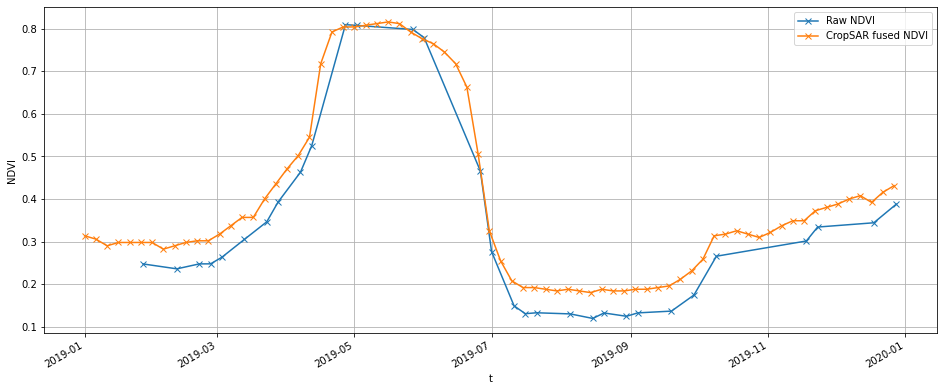

In [57]:
cropsar_ds = xarray.load_dataset(cropsar_output_file)
cropsar = cropsar_ds.NDVI.rename({"t": "time"}) / 255  # from uint8 to float21

fig, ax = plt.subplots(figsize=(16, 6))

raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, marker='x', label='Raw NDVI')
cropsar.median(dim=["x", "y"]).plot(ax=ax, marker='x', label='CropSAR fused NDVI')
ax.legend()
ax.grid()

## PART 3: Phenology calculation

In this final step, we will utilize both the raw and CropSAR-based time series data to extract valuable phenology information. To accomplish this, we will employ the `phenology` service. By leveraging this service, we can extract a range of essential metrics, including the start, peak, and end of the growing season.

The calculation is based on the [phenolopy]() python package.

![phenolopy](https://github.com/lewistrotter/Phenolopy/raw/main/documentation/images/pheno_explain.png?raw=true)


In [58]:
# run phenology on raw NDVI
raw_phenology = phenology(raw_ndvi)

# run phenology on Whittaker smoothed
whittaker_phenology = phenology(smoothed)

# run phenology on MOGPR
mogpr_phenology = phenology(mogpr.to_xarray().NDVI)

# run phenology on fused NDVI
cropsar_phenology = phenology(cropsar)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning calculation of start of season (sos) values and time

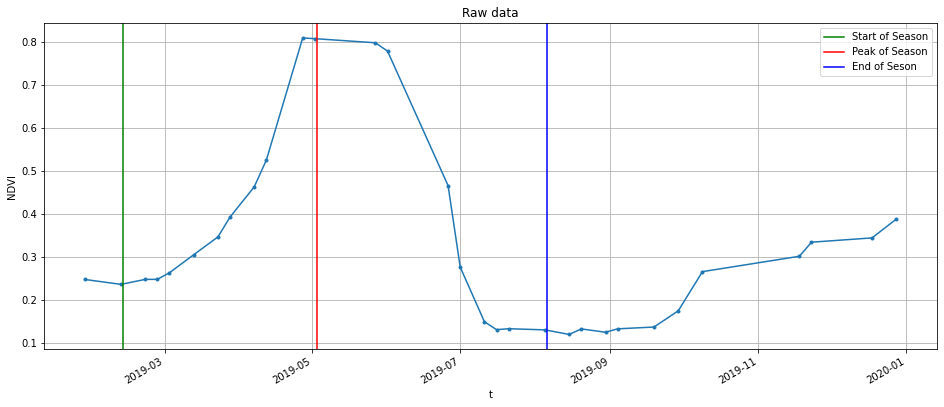

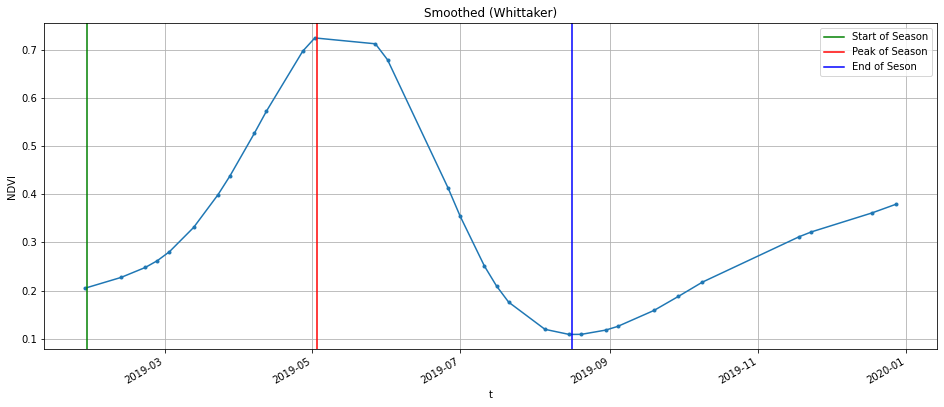

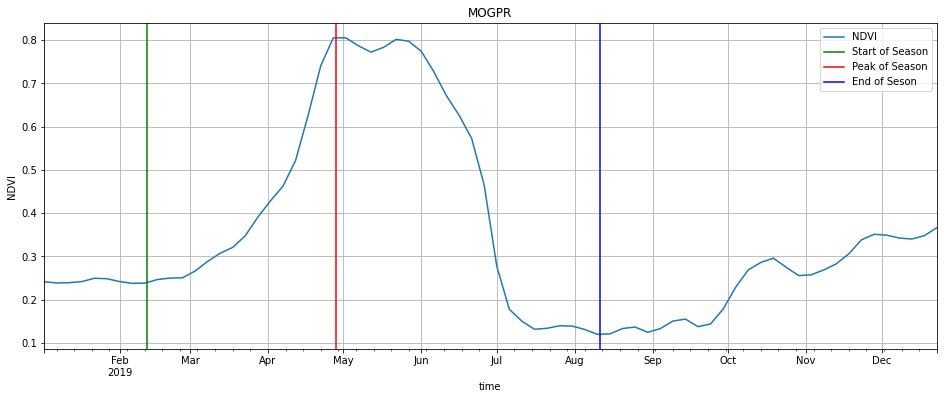

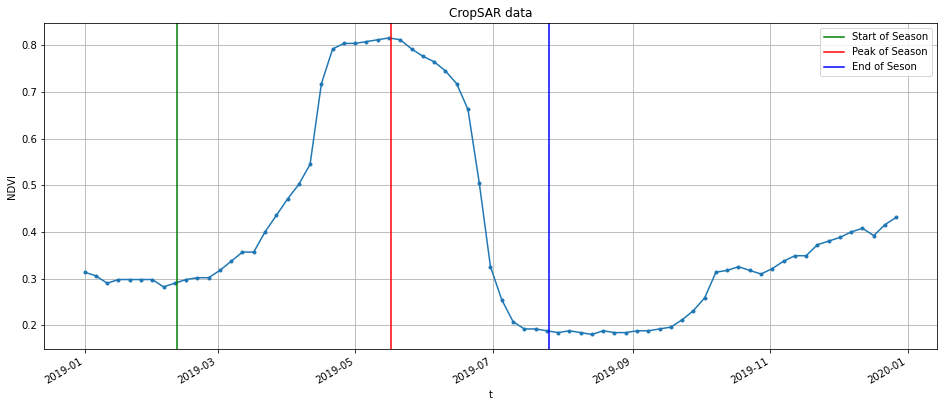

In [59]:
# Utility function to plot extracted phenology metrics
def showPlot(title, data, phenology, average=True, dims=["x", "y"]):

    if average:
        average = data.median(dim=dims)
    
        sos = phenology.sos_times.median(dim=dims).values.take(0)
        pos = phenology.pos_times.median(dim=dims).values.take(0)
        eos = phenology.eos_times.median(dim=dims).values.take(0)
    else:
        average = data
        sos = phenology.sos_times.values.take(0)
        pos = phenology.pos_times.values.take(0)
        eos = phenology.eos_times.values.take(0)


    sos_date = datetime(year, 1, 1) + timedelta(days=sos if not np.isnan(sos) else 0)
    pos_date = datetime(year, 1, 1) + timedelta(days=pos if not np.isnan(pos) else 0)
    eos_date = datetime(year, 1, 1) + timedelta(days=eos if not np.isnan(eos) else 0)

    _, ax = plt.subplots(figsize=(16, 6))

    average.plot.line("C0.-")
    ax.axvline(x=sos_date, color="g", label="Start of Season")
    ax.axvline(x=pos_date, color="r", label="Peak of Season")
    ax.axvline(x=eos_date, color="b", label="End of Seson")

    ax.set_ylabel("NDVI")
    ax.set_title(title)
    ax.grid(True)
    ax.legend()


showPlot("Raw data", raw_ndvi, raw_phenology)
showPlot("Smoothed (Whittaker)", smoothed, whittaker_phenology)
showPlot("MOGPR", mogpr.NDVI, mogpr_phenology, average=False)
showPlot("CropSAR data", cropsar, cropsar_phenology)


The basic phenology metrics (Start Of Season(SOS), Peak Of Season(POS), End Of Season(EOS)) are presented above.
In this case, SOS and EOS are calculated using one of the available methodologies, first of slope. This allows to characterize the seasonality of the crop.

With this last step, an integral workflow is demonstrated: from the raw data acquisition and fused time series generation to the retrieval of phenology metrics.